### Pedro Daia Cardoso

Exercício de treinamento, modelo para distinguir entre a raca de diferentes animais

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 719 kB 32.1 MB/s 
     |████████████████████████████████| 4.4 MB 61.2 MB/s 
     |████████████████████████████████| 1.2 MB 54.9 MB/s 
     |████████████████████████████████| 365 kB 64.0 MB/s 
     |████████████████████████████████| 1.1 MB 49.6 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 212 kB 78.1 MB/s 
     |████████████████████████████████| 140 kB 61.0 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
     |████████████████████████████████| 127 kB 72.7 MB/s 
     |████████████████████████████████| 271 kB 53.9 MB/s 
     |████████████████████████████████| 144 kB 56.1 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 6.6 MB 49.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.1

In [2]:
path = untar_data(URLs.PETS)
Path.BASE_PATH = path
#path.ls()
(path/"images").ls()

(#7393) [Path('images/Abyssinian_114.jpg'),Path('images/Abyssinian_126.jpg'),Path('images/basset_hound_61.jpg'),Path('images/Sphynx_21.jpg'),Path('images/great_pyrenees_44.jpg'),Path('images/basset_hound_111.jpg'),Path('images/Bengal_165.jpg'),Path('images/havanese_15.jpg'),Path('images/Abyssinian_224.jpg'),Path('images/staffordshire_bull_terrier_19.jpg')...]

output:

```
(#2) [Path('images'),Path('annotations')]

(#7393) [Path('images/Maine_Coon_182.jpg'),Path('images/wheaten_terrier_57.jpg'),Path('images/leonberger_177.jpg'),Path('images/Egyptian_Mau_109.jpg'),Path('images/english_cocker_spaniel_52.jpg'),Path('images/Ragdoll_163.jpg'),Path('images/newfoundland_191.jpg'),Path('images/boxer_12.jpg'),Path('images/beagle_86.jpg'),Path('images/pomeranian_126.jpg')...]
```



Temos essa lista de imagens, precisamos extrair os nomes das racas, para isso vamos focar em utilizar Regex. Primeiro, criar um objeto teste de um item aleatorio da lista de imagens, para trabalhar em cima dele as expressoes regulares.

In [3]:
fname = (path/"images").ls()[0]

re.findall(r'(.+)_\d+.jpg$', fname.name)

# (.+)_\d+.jpg$ -> achar todos os characteres,
#           até o ultimo "_" com os próximos caracteres sendo numericos + .jpg

# logo, images/Maine_Coon_182.jpg ----> Maine_Coon

['Abyssinian']

Agora, vamos criar um DataBlock, para aplicar o regex à todos as imagens e ter um dataloader com as labels adquiridas.

In [4]:
petsBlock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                      get_items = get_image_files,
                      splitter = RandomSplitter(seed = 42),
                      get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                      item_tfms = Resize(460), # pra ter ctz q cada img é o msm tamanho
                      batch_tfms = aug_transforms(size = 224, min_scale = 0.75))
dls = petsBlock.dataloaders(path/"images")

# item_tfms: deixa cada img do msm tamanho antes de mandar p GPU
# batch_tfms: crop e alignment aleatorio, de uma vez na batch toda já na GPU

Devemos verificar nosso DataLoader criado, para ter certeza que não cometemos erros na manipulação das imagens, pois até então seria impossível saber se tinha algo errado após o resizing.

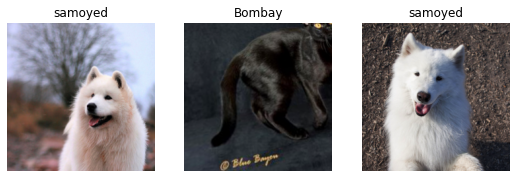

In [5]:
dls.show_batch(nrows = 1, ncols = 3)

In [6]:
petsBlock.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_104.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=476x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_104.jpg
    applying partial gives
      german_shorthaired
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(20)

Final sample: (PILImage mode=RGB size=476x500, TensorCategory(20))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': Fa

Já tendo o DataLoader criado, podemos já testar o modelo; é importante já começar os testes no início do desenvolvimento, para evitar que só descubra erros já visíveis depois de muito tempo.

In [19]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=(1e-3))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.043753,0.395306,0.125846,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.572817,0.258340,0.087280,01:13
1,0.395827,0.219513,0.067659,01:16


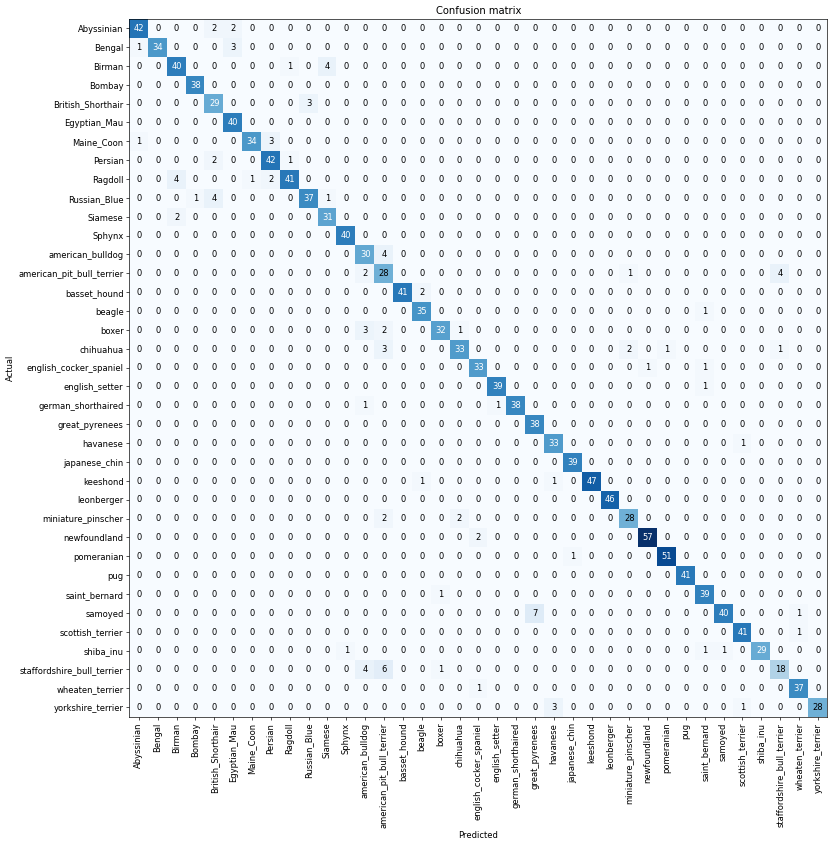

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(14,14), dpi=60)

In [11]:
interp.most_confused(min_val=3)

[('samoyed', 'great_pyrenees', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Birman', 'Siamese', 4),
 ('Ragdoll', 'Birman', 4),
 ('Russian_Blue', 'British_Shorthair', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Maine_Coon', 'Persian', 3),
 ('boxer', 'american_bulldog', 3),
 ('chihuahua', 'american_pit_bull_terrier', 3),
 ('yorkshire_terrier', 'havanese', 3)]

Vamos agora focar em melhorar alguns resultados do nosso modelo.
Comecar pela Learning Rate, observemos o comportamento do treinamento se aumentarmos a learning rate para 0.1 (no treinamento anterior, era a default que é 2e-3)

In [12]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.730843,5.757541,0.515562,01:12


epoch,train_loss,valid_loss,error_rate,time
0,3.373826,1.817248,0.511502,01:15


Podemos ver como o error_rate aumenta, isso porque neste caso invés de pegar pequenos steps, foi muito grande e já foi para um outro extremo, invés de otimizar.

Analisaremos então o comportamento da Learning Rate no modelo:

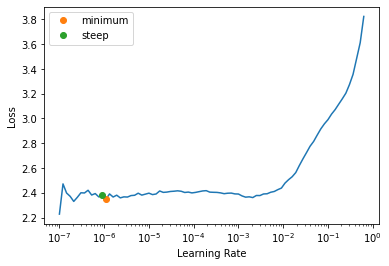

In [13]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [15]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.10e-07, steepest point: 9.12e-07


In [31]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=(2e-3))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.536345,0.295328,0.096752,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.511095,0.283231,0.083221,01:15
1,0.345899,0.208251,0.066982,01:14


Dado o gráfico, observe que em nenhum momento temos uma curva inclinada para baixo, cujo ponto mais inclinado seria o melhor learning rate. Então, nesse caso específico, não há muito a alterar na learning rate. Isso significa que o modelo já está bom, logo é muito mais difícil treiná-lo.

In [34]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.675677,0.298877,0.092693,01:11
1,0.676628,0.218235,0.073072,01:09
2,0.441866,0.203652,0.065629,01:10


In [35]:
learn.unfreeze()

SuggestedLRs(valley=4.365158383734524e-05)

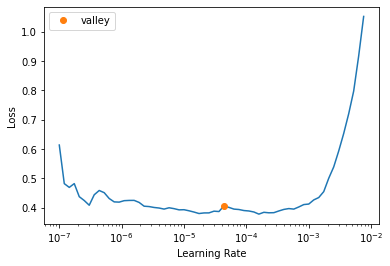

In [36]:
learn.lr_find()

Aqui, treinamos o modelo com somente as últimas camadas aleatórias, enquanto todas as outras estavam freezed, i.é, sem atualizar seus pesos. Após treiná-las com o fit_one_cycle(), pegamos a learning rate finder novamente para ver diferenćas. Observamos uma pequena mudanca.

O mais importante a observar com um gráfico desse é que, a partir de 1e-4, o modelo comeca a piorar novamente, então um bom chute seria buscar o 1e-5 por exemplo. Vamos testar e com um tanto mais de vezes:

In [37]:
learn.fit_one_cycle(6, lr_max=(1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.373247,0.198070,0.066306,01:16
1,0.347452,0.184932,0.060217,01:16
2,0.331383,0.178447,0.060893,01:13
3,0.304487,0.175425,0.059540,01:16
4,0.288353,0.170340,0.058863,01:13
5,0.270275,0.171356,0.056157,01:15


Devemos agora lembrar que, as primeiras camadas, que costumam identificar gradientes e cantos e formas por exemplo, estarão mais bem apropriadas/treinadas para nosso modelo do que as camadas finais, dado o transfer learning, que estariam mais otimizadas para diferentes tarefas. Logo, não faz sentido treinar todas as camadas com a mesma learning rate!

In [38]:
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.256769,0.167060,0.056834,01:16
1,0.258250,0.168487,0.058863,01:13
2,0.242685,0.160210,0.060217,01:15
3,0.226599,0.156262,0.052774,01:14
4,0.202793,0.157105,0.054127,01:15
5,0.183170,0.158473,0.052774,01:14
6,0.166367,0.150902,0.050744,01:15
7,0.165766,0.150438,0.050068,01:15
8,0.150727,0.152690,0.048714,01:13
9,0.157437,0.151297,0.048714,01:15


Nosso modelo melhorou! É importante entender quando já está o suficiente: o quanto antes puder botar em prática de verdade o seu modelo, melhor. Os resultados atuais já são suficientemente bons para um classificador de 37 tipos de animais diferentes. Podemos sempre aumentar as camadas, isto é, usar uma arquitetura mais profunda (deeper architecture), como uma ResNet50, ResNet101, ResNet152, mas isso utilizará mais memória da GPU e não necessariamente será de fato mais eficiente para nosso uso.

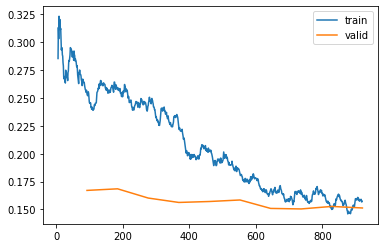

In [39]:
learn.recorder.plot_loss()